In [5]:
import pandas as pd

# Loading

In [6]:
# Read csv
df = pd.read_csv('..\\0_Data\\processed\\final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)
df.head(2)

,Hour,Little Collins St-Swanston St (East),Faraday St-Lygon St (West),Melbourne Central,Chinatown-Lt Bourke St (South),Lonsdale St (South),Lygon St (West),IsPublicHoliday,temp,humidity,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Season_Spring,Season_Summer,Season_Winter
2022-04-01 00:00:00,0,166.0,24.0,380.0,73.0,215.0,48.0,0,16.90,59,...,0,0,0,0,0,0,0,1,0,0
2022-04-01 01:00:00,1,108.0,9.0,198.0,79.0,156.0,11.0,0,17.28,58,...,0,0,0,0,0,0,0,1,0,0


In [7]:
train = df[df.index < "2024-10-16"]
test = df[df.index >= "2024-10-16"]

# SARIMA

In [ ]:
train.columns

## Staionary d

In [8]:
from statsmodels.tsa.stattools import adfuller

target_column = ['Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)']

for column in target_column:
    print(column)
    result = adfuller(train[column])
    print('p-value:', result[1])  # A p-value > 0.05 indicates non-stationarity.


Little Collins St-Swanston St (East)
p-value: 4.194439779431661e-27
Faraday St-Lygon St (West)
p-value: 0.0
Melbourne Central
p-value: 9.272613098077206e-27
Chinatown-Lt Bourke St (South)
p-value: 0.0
Lonsdale St (South)
p-value: 0.0
Lygon St (West)
p-value: 0.0


No differnecing needed

In [ ]:
d = 0

## Seasonal

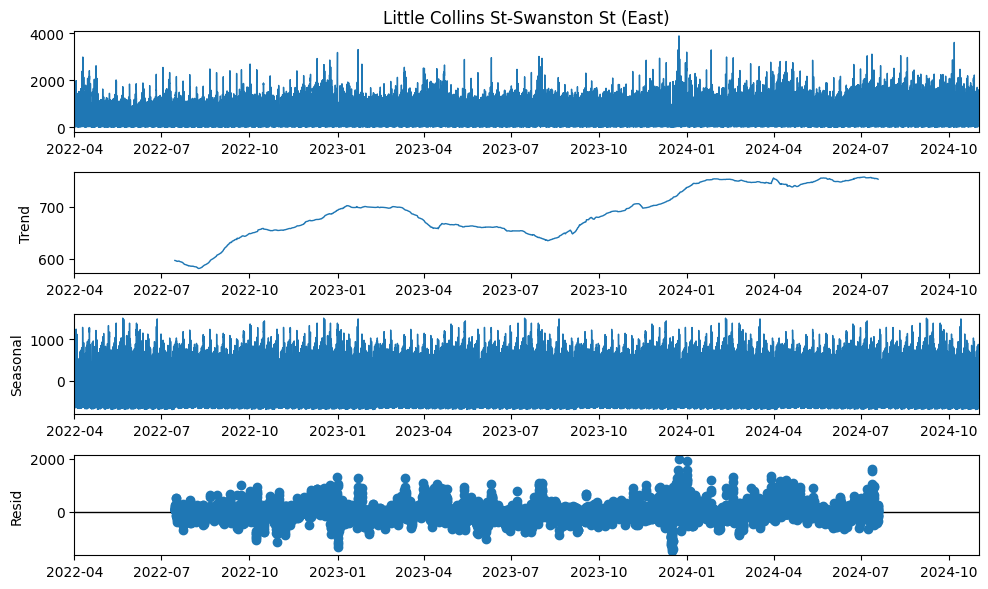

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_2 = df

decomposition = seasonal_decompose(df_2['Little Collins St-Swanston St (East)'], model='additive', period=24*7*30)  # e.g., 24 for hourly data
fig = decomposition.plot()
# Make lines thinner
for ax in fig.axes:
    plt.setp(ax.lines, linewidth=1)

fig.set_size_inches(10, 6)  # Width x Height in inches
fig.tight_layout()  # Adjust spacing
plt.show()


In [ ]:
S = 24

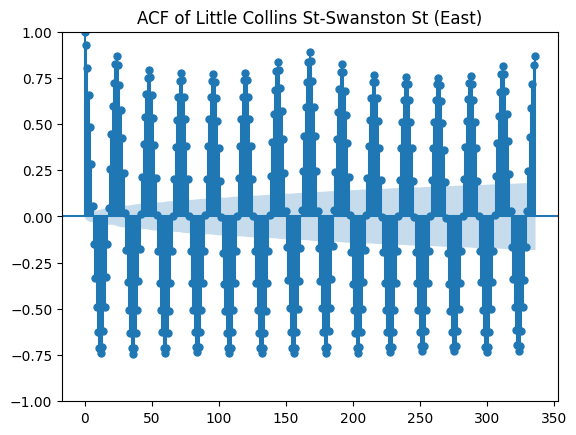

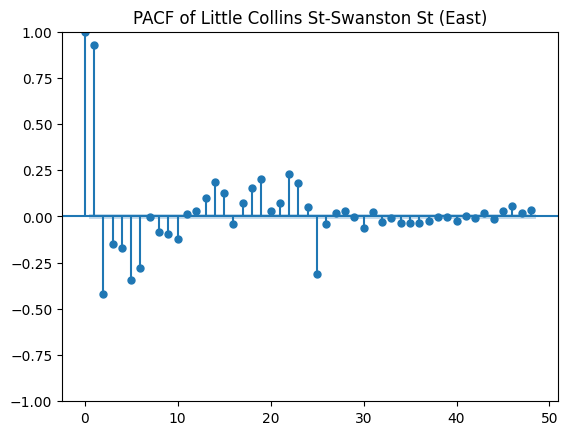

In [ ]:
# Give a ACF and PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train['Little Collins St-Swanston St (East)'], lags=24*7*)
# Cangte the title to include Little Collins St-Swanston St (East)
plt.title('ACF of Little Collins St-Swanston St (East)')
plt.show()

plot_pacf(train['Little Collins St-Swanston St (East)'], lags=24*2)
plt.title('PACF of Little Collins St-Swanston St (East)')
plt.show()


## Parameter search

In [ ]:
import itertools
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm  # For progress bar

# Define parameter ranges
p = q = range(0, 4)  # Range for p and q
d = 0                # Fixed d
P = D = Q = range(0, 3)  # Range for seasonal P, D, Q
m = 24               # Daily seasonality

train = train.asfreq('H')

# Generate all parameter combinations
pdq = [(p_val, d, q_val) for p_val in p for q_val in q]  # Fix d = 0
print("Non-seasonal combinations (p, d, q):", pdq)

seasonal_pdq = [(P_val, D_val, Q_val, m) for P_val in P for D_val in D for Q_val in Q]
print("Seasonal combinations (P, D, Q, m):", seasonal_pdq)

total_combinations = len(pdq) * len(seasonal_pdq)

# Initialize a dictionary to store the best results for each column
best_results = {}

columns = ['Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)']

# Iterate over columns
for column in columns:
    print(f"Processing column: {column}")
    
    # Reset best AIC and parameters for each column
    best_aic = float('inf')
    best_params = None
    
    # Progress bar
    progress_bar = tqdm(total=total_combinations, desc=f"Testing SARIMAX for {column}")
    
    # Grid search over all parameter combinations
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                # Fit the model
                model = SARIMAX(
                    train[column],
                    order=param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                # Check if the model is better
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, seasonal_param)

            except Exception as e:
                # Handle exceptions (e.g., convergence issues) silently
                pass

            # Update the progress bar
            progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    # Store the best parameters and AIC for this column
    best_results[column] = {'params': best_params, 'aic': best_aic}

    print(f"Best SARIMAX parameters for {column}: {best_params} with AIC: {best_aic}")

# Display the results for all columns
for col, result in best_results.items():
    print(f"Column: {col}, Best Params: {result['params']}, Best AIC: {result['aic']}")


Column: Little Collins St-Swanston St (East): ((1, 0, 2), (1, 1, 1, 24)) with AIC: 230806.7825760926 <br>
Column: Faraday St-Lygon St (West), Best Params: ((1, 0, 2), (1, 1, 1, 24)), Best AIC: 190003.90829115754 <br>
Column: Melbourne Central, Best Params: ((1, 0, 2), (1, 1, 1, 24)), Best AIC: 233857.60412778181 <br>
Column: Chinatown-Lt Bourke St (South), Best Params: ((1, 0, 2), (1, 1, 1, 24)), Best AIC: 219997.16664512668 <br>
Column: Lonsdale St (South), Best Params: ((2, 0, 1), (1, 1, 1, 24)), Best AIC: 208037.09922881392 <br>
Column: Lygon St (West), Best Params: ((2, 0, 2), (1, 1, 1, 24)), Best AIC: 195383.3819879219 <br>

## Fit SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
best_params = {
    'Little Collins St-Swanston St (East)': ((1, 0, 2), (1, 1, 1, 24)),
    'Faraday St-Lygon St (West)': ((1, 0, 2), (1, 1, 1, 24)),
    'Melbourne Central': ((1, 0, 2), (1, 1, 1, 24)),
    'Chinatown-Lt Bourke St (South)': ((1, 0, 2), (1, 1, 1, 24)),
    'Lonsdale St (South)': ((2, 0, 1), (1, 1, 1, 24)),
    'Lygon St (West)': ((2, 0, 2), (1, 1, 1, 24))
}

trained_models = {}

for column, (order, seasonal_order) in best_params.items():
    print(f"Training SARIMAX model for column: {column}")
    
    # Define the SARIMAX model
    model = SARIMAX(
        train[column],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Fit the model
    results = model.fit(disp=False)
    trained_models[column] = results
    
    # Save the trained model to a file
    with open(f'{column.replace(" ", "_")}_sarimax_model.pkl', 'wb') as file:
        #pickle.dump(results, file)
    
    print(f"Model for {column} saved successfully.")

#### Load

## Test

In [ ]:
import pickle

# Define the column names to match the saved models
columns = [
    'Little Collins St-Swanston St (East)',
    'Faraday St-Lygon St (West)',
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)',
    'Lygon St (West)'
]

# Initialize a dictionary to store the loaded models
loaded_models = {}

# Load each model
for column in columns:
    file_name = f'{column.replace(" ", "_")}_sarimax_model.pkl'
    try:
        with open(file_name, 'rb') as file:
            loaded_models[column] = pickle.load(file)
        print(f"Model for {column} loaded successfully.")
    except FileNotFoundError:
        print(f"Model file for {column} not found: {file_name}")

# Check loaded models
print("Loaded models:", list(loaded_models.keys()))


In [ ]:
# Example: Predict for one column
columns = [
    'Little Collins St-Swanston St (East)',
    'Faraday St-Lygon St (West)',
    'Melbourne Central',
    'Chinatown-Lt Bourke St (South)',
    'Lonsdale St (South)',
    'Lygon St (West)'
]

column = 'Little Collins St-Swanston St (East)'
model = loaded_models[column]

# Generate predictions
start = test.index[0]
end = test.index[-1]

predictions = model.get_prediction(start=start, end=end)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

# Combine predictions with test data
test_results = test.copy()
test_results['Predicted'] = predicted_mean
test_results['Lower_CI'] = confidence_intervals.iloc[:, 0]
test_results['Upper_CI'] = confidence_intervals.iloc[:, 1]

print(test_results.head())


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index[:200], test['Little Collins St-Swanston St (East)'][:200], label='Actual')
plt.plot(test.index[:200], test_results['Predicted'][:200], label='Predicted', color='red')
plt.fill_between(test.index[:200], 
                 test_results['Lower_CI'][:200], 
                 test_results['Upper_CI'][:200], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('SARIMAX Predictions vs Actuals')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['Little Collins St-Swanston St (East)'], test_results['Predicted'])
rmse = np.sqrt(mean_squared_error(test['Little Collins St-Swanston St (East)'], test_results['Predicted']))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


## Check for Resid

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Little Collins St-Swanston St (East)'],
                order=(1, 1, 0),
                seasonal_order=(1, 0, 0, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15, 8))


In [ ]:
import matplotlib.pyplot as plt

# Residuals from the fitted model
residuals = sarimax_results.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.axhline(0, linestyle='--', color='r', alpha=0.7)
plt.show()


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plot_acf(residuals, lags=10, alpha=0.05)
plt.title('ACF of Residuals')
plt.show()

# PACF plot
plot_pacf(residuals, lags=10, alpha=0.05)
plt.title('PACF of Residuals')
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test
ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box)


## Alternative

In [ ]:
# Read csv
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

df = pd.read_csv('..\\0_Data\\processed\\final_df.csv', parse_dates=True, index_col=0)
df.index = pd.to_datetime(df.index)


df_save = df.copy()

def RMSE(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


In [ ]:
len(train)/3*2


In [ ]:
import pmdarima as pm
columns = ['Little Collins St-Swanston St (East)',
       'Faraday St-Lygon St (West)', 'Melbourne Central',
       'Chinatown-Lt Bourke St (South)', 'Lonsdale St (South)',
       'Lygon St (West)']
columns = ['Little Collins St-Swanston St (East)']

for colum in columns:
       df = df_save.copy()
       name = f"{colum}_lag1"
       name2 = f"{colum}_lag24"
       df[name] = df[colum].shift(1)
       df[name2] = df[colum].rolling(window=24).mean()
       df = df.dropna()

       train = df[df.index < "2024-10-16"]

       lenght = 10000
       train = train[lenght:]


       test = df[df.index >= "2024-10-16"]

       X_train = train.drop(columns=colum)
       X_test = test.drop(columns=colum)
       y_train = train[colum]
       y_test = test[colum]

       sarimax_model = pm.auto_arima(y_train, X_train=X_train, seasonal=True, m=24,
                                trace=True, error_action='ignore',  
                                suppress_warnings=True, stepwise=True, 
                                test='adf')

       print(sarimax_model.summary())

       y_pred = sarimax_model.predict(X_test)
       rmse = RMSE(y_test, y_pred)
       print(f"From {column} RMSE is {rmse}")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
best_params = {
    'Little Collins St-Swanston St (East)': ((1, 0, 2), (1, 1, 1, 24)),
    'Faraday St-Lygon St (West)': ((1, 0, 2), (1, 1, 1, 24)),
    'Melbourne Central': ((1, 0, 2), (1, 1, 1, 24)),
    'Chinatown-Lt Bourke St (South)': ((1, 0, 2), (1, 1, 1, 24)),
    'Lonsdale St (South)': ((2, 0, 1), (1, 1, 1, 24)),
    'Lygon St (West)': ((2, 0, 2), (1, 1, 1, 24))
}

import pmdarima as pm
best_params = {
    'Little Collins St-Swanston St (East)': ((1, 0, 2), (1, 1, 1, 24))}

for column, (order, seasonal_order) in best_params.items():

    df = df_save.copy()
    name = f"{colum}_lag1"
    name2 = f"{colum}_lag24"
    df[name] = df[colum].shift(1)
    df[name2] = df[colum].rolling(window=24).mean()
    df = df.dropna()

    train = df[df.index < "2024-10-16"]

    lenght = 10000
    train = train[lenght:]


    test = df[df.index >= "2024-10-16"]

    X_train = train.drop(columns=colum)
    X_test = test.drop(columns=colum)
    y_train = train[colum]
    y_test = test[colum]

    print(f"Training SARIMAX model for column: {column}")
    
    # Define the SARIMAX model
    model = SARIMAX(
        y_train,
        exog = X_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Fit the model
    results = model.fit(disp=False)
    
    print(f"Model for {column} saved successfully.")

    # Predict future values
    forecast = results.get_forecast(steps=len(X_test), exog=X_test)

    # Extract the predicted mean values
    predicted_values = forecast.predicted_mean

    rmse = RMSE(y_test, predicted_values)
    print(f"From {column} RMSE is {rmse}")

# GARCH

# Try TBATS 

https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a